线性判别分析Linear Discriminant Analysis.    
平方判别分析 Quadratic Discriminant Analysis.

LDA, QDA

isotropic 各向同性。在所有方向上分布相同。    
isotropic_covariance：

### makedata 

In [51]:
def make_data(n_samples, n_features, linear_transform_class_1, linear_transform_class_2, seed=0):
    rng = np.random.RandomState(seed)
    # 实际的cov 为 transform.T * transform
    X = np.concatenate(
        [
            rng.randn(n_samples, n_features) @ linear_transform_class_1,
            rng.randn(n_samples, n_features) @ linear_transform_class_2 + np.array([1, 1]), # 向右上平移
        ]
    )
    y = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])
    return X, y

### 简单认识

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

情形1： 两个类别具有相同的协方差矩阵, 且协方差具有球面特性

In [52]:
linear_transform = np.array([
    [1, 0],
    [0, 1]
])
X, y = make_data(
    n_samples=1000,
    n_features=2,
    linear_transform_class_1=linear_transform,
    linear_transform_class_2=linear_transform,
    seed=0
)

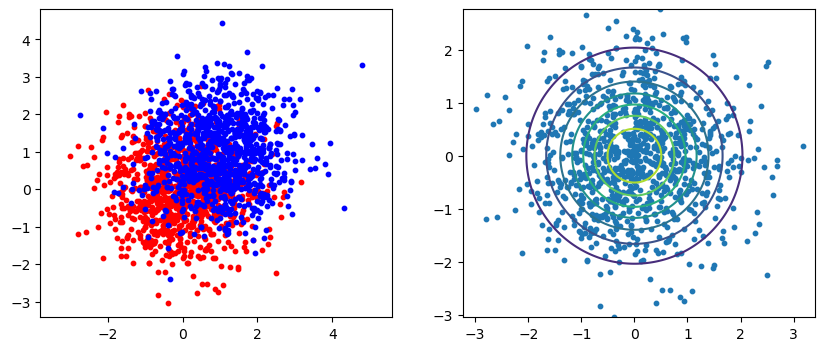

<Figure size 400x400 with 0 Axes>

In [53]:
# 二维等高线图，
def plot_contour(x1, x2, y_func, ax):
    fig = plt.figure(figsize=(4,4))
    x1_space = np.linspace(min(x1), max(x1), 1000)
    x2_space = np.linspace(min(x2), max(x2), 1000)
    x1_grid, x2_grid = np.meshgrid(x1_space, x2_space)
    y_grid = y_func(np.column_stack([x1_grid.ravel(), x2_grid.ravel()]))
    y_grid = y_grid.reshape(x1_grid.shape)
    
    ax.contour(x1_grid, x2_grid, y_grid)
    ax.scatter(x1, x2, s=10)
    ax.axis('equal')
rv = multivariate_normal(mean=[0, 0], cov= covariance.T @ covariance)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].scatter(X[:1000, 0], X[:1000, 1], s= 10, c='red')
axes[0].scatter(X[1000:, 0], X[1000:, 1], s= 10, c='blue')
axes[0].axis('equal')

plot_contour(X[:1000, 0], X[:1000, 1], y_func=rv.pdf, ax=axes[1])

## 比较LDA和QDA
- LDA和QDA都假设服从高斯分布
- LDA的每类协方差矩阵相同，决策边界是直线
- QDA的每类协方差矩阵不同，决策边界是曲线

In [85]:
# 数据分布协方差 园
linear_transform = np.array([
    [1, 0],
    [0, 1]
])
X_isotropic_covariance, y_isotropic_covariance = make_data(
    n_samples=1000,
    n_features=2,
    linear_transform_class_1=linear_transform,
    linear_transform_class_2=linear_transform,
    seed=0
)
# 两类数据同分布协方差 椭圆
linear_transform = np.array([
    [0, -0.23],
    [0.83, 0.23]
])
X_shared_covariance, y_shared_covariance = make_data(
    n_samples=1000,
    n_features=2,
    linear_transform_class_1=linear_transform,
    linear_transform_class_2=linear_transform,
    seed=0
)
# 两类数据不同分布协方差 椭圆
linear_transform_1 = np.array([
    [0, -1],
    [2.5, 0.7]
]) * 2.0
linear_transform_2 = linear_transform_1.T
X_diffierent_covariance, y_diffierent_covariance = make_data(
    n_samples=1000,
    n_features=2,
    linear_transform_class_1=linear_transform_1,
    linear_transform_class_2=linear_transform_2,
    seed=0
)


In [86]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib import colors
from matplotlib.patches import Ellipse
def plot_ellipse(mean, cov, color, ax):
    eig_vals, eig_vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*eig_vecs[:, 1][::-1]))
    # print(f'Ell : width:{eig_vals[1]}, height :{eig_vals[0]}, angle : {angle}, xy = {mean}')
    ell = Ellipse(
        xy= mean,
        width= eig_vals[1],
        height= eig_vals[0],
        angle = angle,
        alpha = 0.4,
        facecolor=color,
        linewidth=2
    )
    ax.add_patch(ell)

def plot_result(estimator, X, y, ax):
    """ 绘制：
    1. 决策边界
    2. 散点
    3. 中心点
    4. cov椭圆
    """
    cmap = colors.ListedColormap(['tab:red', 'tab:blue'])
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method = 'predict_proba',
        plot_method = 'pcolormesh',
        ax = ax,
        cmap = 'RdBu',
        alpha = 0.3
    )
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5],
    )
    y_pred = estimator.predict(X)
    X_right, y_right = X[y == y_pred], y[y == y_pred]
    X_wrong, y_wrong = X[y != y_pred], y[y != y_pred]
    ax.scatter(X_right[:, 0], X_right[:, 1], c=y_right, s=20, alpha=0.5, cmap=cmap)
    ax.scatter(X_wrong[:, 0], X_wrong[:, 1], c=y_wrong, s=20, alpha=0.9, marker ='x',cmap=cmap)
    ax.scatter(estimator.means_[:, 0], estimator.means_[:, 1], c='yellow', s=100,marker='*')
    # ellipse
    if isinstance(estimator, LinearDiscriminantAnalysis):
        covariance = [estimator.covariance_] * 2 # linear由于两类相同，就只记录了一个
    else:
        covariance = estimator.covariance_
    plot_ellipse(estimator.means_[0], covariance[0], 'red', ax)
    plot_ellipse(estimator.means_[1], covariance[1], 'blue', ax)

Text(0.5, 0.98, 'LDA VS QDA')

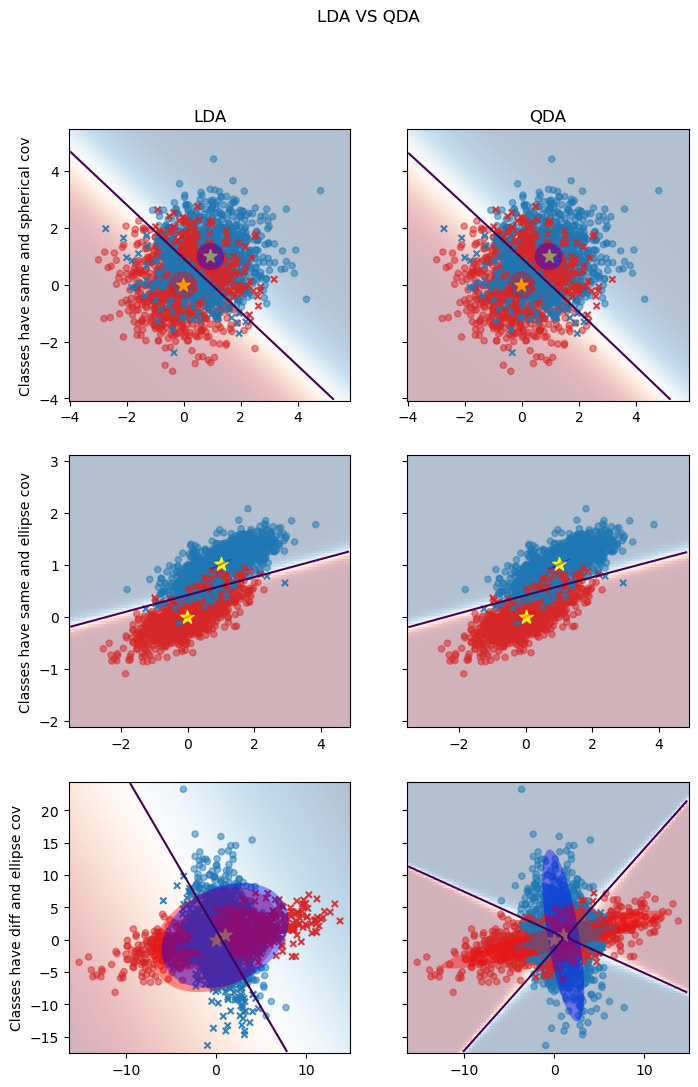

In [87]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
lda = LinearDiscriminantAnalysis(
    solver= 'svd',
    store_covariance=True
)
qda = QuadraticDiscriminantAnalysis(
    store_covariance=True
)
fig, axes = plt.subplots(nrows=3, ncols=2, sharex='row', sharey='row', figsize=(8,12))

for ax_row, X, y in zip(
    axes,
    (X_isotropic_covariance, X_shared_covariance, X_diffierent_covariance),
    (y_isotropic_covariance, y_shared_covariance, y_diffierent_covariance),
):
    lda.fit(X, y)
    plot_result(lda, X, y, ax_row[0])
    qda.fit(X, y)
    plot_result(qda, X, y, ax_row[1])
axes[0, 0].set_title('LDA')
axes[0, 0].set_ylabel('Classes have same and spherical cov')
axes[1, 0].set_ylabel('Classes have same and ellipse cov')
axes[2, 0].set_ylabel('Classes have diff and ellipse cov')
axes[0, 1].set_title('QDA')
fig.suptitle(
    'LDA VS QDA',
)

## 结论：    
可以看到QDA比LDA更加灵活，对同cov和不同cov的数据都能更好的分类。

## 问题：
对于高维，小样本的表现会有什么不同？？？